In [175]:
import ee
import geemap
from geemap import ml
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor



In [180]:
ee.Authenticate()

Enter verification code:  4/1ARtbsJqcdl5y4DL-H_I_Q0O8fOeQXfeHtqzgV9LpjyFGkiyKUrmes9sQADA



Successfully saved authorization token.


In [181]:
ee.Initialize() 

In [172]:
def parseSamples(bucketName,fileSuffix):

    # specify sampled files for calibation
    # rows in each file match
    file_name = ['LUTinputLC0XB36', 'LUTinputLC0XB45','LUTinputMOD09' ,'LUTinputLC0XLat', \
                 'LUTinputLC0XLon','LUToutputLC0X','YearLC0X','MonthLC0X', \
                 'DayLC0X','PathLC0X','RowLC0X']
    
    # read files in to dictionary 
    dataset = {}
    for name in file_name:
        name_dataset = bucketName+name+fileSuffix
        if ( 'gs:' not in bucketName ) :
            with open(f'{name_dataset}', 'rb') as fp1:
                objs = []
                while 1:
                    try:
                        objs.append(pickle.load(fp1))
                    except EOFError:
                        break
                dataset[name] = [item for sublist in objs for item in sublist]
        else: 
                    dataset[name] = (pd.read_pickle(name_dataset))

                
    # parse the LUTs into Pandas tables
    LUT_Lai = np.double(np.floor(np.mod(np.array(dataset['LUToutputLC0X']),1e2)/1e0))
    LUT_LaiStdDev = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUToutputLC0X']),1e4)/1e2)))
    LUT_Fpar = np.double(np.floor(np.mod(np.array(dataset['LUToutputLC0X']),1e6))/1e4)
    LUT_FparStdDev = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUToutputLC0X']),1e8)/1e6)))
    LUT_satFlag = np.uint64(np.floor(np.mod(np.array(dataset['LUToutputLC0X']),1e11))/1e8)
    LUT_snowFlag = np.uint64(np.floor(np.floor(np.mod(np.array(dataset['LUToutputLC0X']),1e14)/1e11)))
    LUT_LC_Type3 = np.uint64(np.floor(np.floor(np.mod(np.array(dataset['LUToutputLC0X']),1e16)/1e14)))
    LUT_SR_B3 = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputLC0XB36']),1e3)/1)))
    LUT_SR_B4 = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputLC0XB45']),1e3)/1)))
    LUT_SR_B5 = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputLC0XB45']),1e6)/1e3)))
    LUT_SR_B6 = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputLC0XB36']),1e6)/1e3)))
    LUT_VIEW_ZENITH = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputLC0XB45']),1e8)/1e6)))
    LUT_VIEW_AZIMUTH = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputLC0XB45']),1e11)/1e8)))
    LUT_SUN_ELEVATION = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputLC0XB45']),1e13)/1e11)))
    LUT_SUN_AZIMUTH = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputLC0XB45']),1e16)/1e13)))
    LUT_MOD09_red = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputMOD09']),1e4)/1)))
    LUT_MOD09_NIR = np.double(np.floor(np.floor(np.mod(np.array(dataset['LUTinputMOD09']),1e8)/1e4)))
    LUT_MSUN_ZENITH = np.uint64(np.floor(np.floor(np.mod(np.array(dataset['LUTinputMOD09']),1e10)/1e8)))
    LUT_MSUN_AZIMUTH = np.uint64(np.floor(np.floor(np.mod(np.array(dataset['LUTinputMOD09']),1e13)/1e10)))
    LUT_MVIEW_ZENITH = np.uint64(np.floor(np.floor(np.mod(np.array(dataset['LUTinputMOD09']),1e15)/1e13)))
    LUT_MVIEW_AZIMUTH = np.uint64(np.floor(np.floor(np.mod(np.array(dataset['LUTinputMOD09']),1e18)/1e15)))
    
    # make pandas frame of all coded inputs
    return pd.DataFrame( {'year':dataset['YearLC0X'], 'month': dataset['MonthLC0X'], 'day': dataset['DayLC0X'], 'path':dataset['PathLC0X'], 'row':dataset['RowLC0X'],\
                          'Lat':dataset['LUTinputLC0XLat'], 'Lon':dataset['LUTinputLC0XLon'], 'input36': dataset['LUTinputLC0XB36'],'input45':dataset['LUTinputLC0XB45'], \
                           'inputMOD09': dataset['LUTinputMOD09'], 'redMODIS': LUT_MOD09_red,'NIRMODIS': LUT_MOD09_NIR,\
                          'green':LUT_SR_B3 * 10, 'red':LUT_SR_B4 * 10, 'NIR': LUT_SR_B5 * 10, 'SWIR1': LUT_SR_B6 * 10,   \
                          'SensorZenith':LUT_VIEW_ZENITH, 'SensorAzimuth': LUT_VIEW_AZIMUTH, 'SolarZenith':LUT_SUN_ELEVATION, 'SolarAzimuth': LUT_SUN_AZIMUTH, \
                          'M_sensor_zenith':LUT_MVIEW_ZENITH, 'M_sensor_azimuth': LUT_MVIEW_AZIMUTH, 'M_sun_zenith':LUT_MSUN_ZENITH, 'M_sun_azimuth': LUT_MSUN_AZIMUTH, \
                          'LC_type3': LUT_LC_Type3, 'output': dataset['LUToutputLC0X'],'LAI': LUT_Lai, 'stdLAI': LUT_LaiStdDev, 'FAPAR': LUT_Fpar, 'stdFAPAR': LUT_FparStdDev,\
                          'LUT_satFlag': LUT_satFlag,'LUT_snowFlag': LUT_snowFlag,'LC_type3': LUT_LC_Type3}) \
               .sort_values('input36')        


In [169]:
# trims a dataframe of outliers of the conditional distribution of y given x using fixed sample sizesd
def trimDFNumSample(df,x,y,percentiles,bins,numsamples):
    # sort DF by the x value to speed up subsetting
    dropList = []
    sortList = df.sort_values(by=x).reset_index()
    for i in bins:
        # find location of value nearest to current bin
        binIndex = sortList.loc[sortList[x]>i].index
        if not binIndex.empty:
            lenList = len(sortList)
            Sample = sortList.iloc[(np.maximum((binIndex[0]-100),0)):(np.minimum((binIndex[0]+100), lenList))]
            if not Sample.empty:
                dropList.append(Sample.loc[Sample[y]<np.percentile(Sample[y],percentiles[0])]['index'].values.tolist()) 
                dropList.append(Sample.loc[Sample[y]>np.percentile(Sample[y],percentiles[1])]['index'].values.tolist())
    return df.drop(sum(dropList,[]))

In [170]:
# trim calibration data based on comparing Landsat and MODIS equivalents
# note we oversample the MODIS axis as we trim
# this takes some time

def trimDF(df):

    # thresholds 
    df = df[(df.redMODIS < 100) & (df.red > 0) & (df.green > 0 ) & (df.NIR > 0 ) & (df.red < np.quantile(df.red,0.99)) & (df.green < np.quantile(df.green,0.99)) \
             & (df.NIR < np.quantile(df.NIR,0.995)) & (df.SWIR1 < np.quantile(df.SWIR1,0.99)) & (df.M_sensor_zenith<20)]
 

    # trim based on red
    df = trimDFNumSample(df,'redMODIS','red',[10,90],np.arange(100,1000.0,10),10000)

    #trim based on nir
    df = trimDFNumSample(df,'NIRMODIS','NIR',[10,90],np.arange(100,1000.0,10),10000)
  
    return df

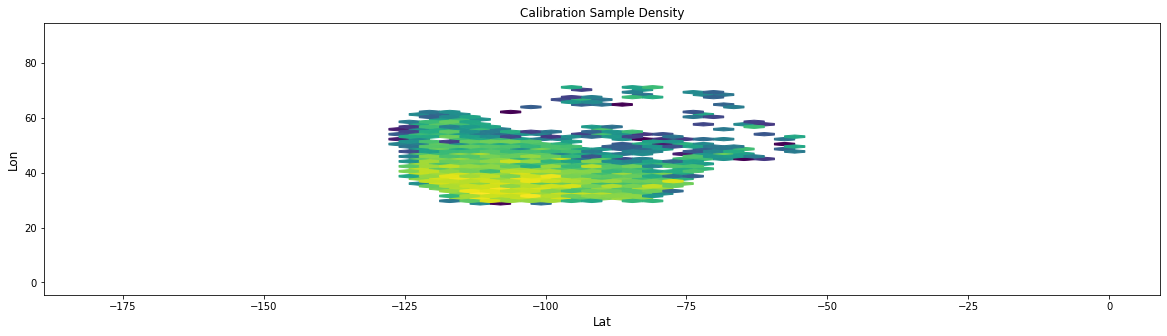

In [173]:
# read calibration data and display locations 
# does not seem to read entire file from Goolge, so now using local drive
#bucketName = 'gs://modislandsat/calibrationVersion5/NorthAmerica/' 
bucketName = '/home/richard_fernandes/modislandsat/Calibrationv5/NorthAmerica/'
fileSuffix = 'calv7'
geeClassifierRootName = '/treesModisLandsatNAv5'
dfALL= trimDF(parseSamples(bucketName,fileSuffix))
fig,ax = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(20)
im=ax.hexbin(dfALL['Lon'],dfALL['Lat'], gridsize=(50,50), extent=(-180,0,0,90),bins='log')
ax.set_xlabel('Lat',size = 12)
ax.set_ylabel('Lon',size = 12)
ax.set_title('Calibration Sample Density')
plt.show()

In [184]:
rawfeatures = ['green', 'red', 'NIR', 'SWIR1','SolarAzimuth','SolarZenith']
response= ['LAI']
geeClassifierRootName = '/treesModisLandsatNAv5Biome'

In [186]:
# calibrate and export random forests to GEE as feature collections
# to parse these into classifiers see https://geemap.org/notebooks/46_local_rf_training/#convert-a-sklearn-classifier-object-to-a-list-of-strings
# you can also export as local binary files and not feature collections, faster but then this is not as transparent as usig GEE objects
forests = {}
for biome in dfALL['LC_type3'].unique():
    df = dfALL.loc[dfALL['LC_type3']==biome]
    print(biome,df.shape[0])
    forests[str(biome)] = RandomForestRegressor(n_estimators=2,min_samples_leaf=10,bootstrap=True,random_state=0,verbose=0,max_leaf_nodes=10000).fit(df[rawfeatures], np.array(df[response]).ravel())
 
     # create a ee classifier to use with ee objects from the trees
    trees = ml.rf_to_strings(forests[str(biome)], rawfeatures,output_mode='REGRESSION') 
    
    # kick off an export process so it will be saved to the ee asset
    ml.export_trees_to_fc(trees, geemap.ee_user_id() + geeClassifierRootName + str(biome))
    


4 70658
2 59954
1 177779
7 17019
10 306
6 15757
3 10938
9 9168
5 1054
8 182


In [188]:
# read the exported tree feature collection
rf_fc = ee.FeatureCollection('users/richardfernandes/treesModisLandsatNAv51')

# convert it to a classifier, very similar to the `ml.trees_to_classifier` function
another_classifier = ml.fc_to_classifier(rf_fc)

print(another_classifier.getInfo())

{'type': 'Classifier.decisionTreeEnsemble', 'treeStrings': ['1) root 112534 9999 9999 (8330.706850718416)\n  2) red <= 755.000000 112534 30.5970 5.897755\n    4) NIR <= 2675.000000 17332 78.7626 13.148777\n      8) SolarZenith <= 43.500000 10199 26.6386 8.419785\n        16) NIR <= 2205.000000 4917 20.2321 11.728226\n          32) red <= 575.000000 2970 17.3419 10.270043\n            64) NIR <= 1715.000000 1157 22.5110 12.259076\n              128) NIR <= 1085.000000 116 19.6366 7.632979 *\n              129) NIR > 1085.000000 492 19.1380 10.174843\n                258) red <= 415.000000 104 23.8157 14.079755 *\n                259) red > 415.000000 376 16.3626 10.962109\n                  518) SolarZenith <= 34.500000 157 6.0376 10.856589 *\n                  519) SolarZenith > 34.500000 115 8.9336 8.376344 *\n            65) NIR > 1715.000000 1157 22.5110 12.259076\n              130) SolarZenith <= 36.500000 665 19.1329 13.878788\n                260) SWIR1 <= 1475.000000 173 24.263